In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxitrain/taxi_final_train.csv
/kaggle/input/clean-taxi-dataset/clean_taxi_dataset.csv


In [2]:
pip install gensim==3.8.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scattertext 0.1.6 requires gensim>=4.0.0, but you have gensim 3.8.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [4]:
import gensim

In [5]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras.preprocessing.text
from tensorflow.keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('../input/taxitrain/taxi_final_train.csv', encoding='utf8', dtype=object)

In [7]:
df = df.drop(columns=['label'])

In [8]:
df.columns.values

array(['f_name', 'l_name', 'gender', 'area_code', 'phone', 'city',
       'state', 'zip', 'marital_status', 'has_child', 'salary', 'rate',
       'single_exemp', 'married_exemp', 'child_exemp'], dtype=object)

In [9]:
values = []
for i in df.columns:
    values.append(df[i].tolist())

In [10]:
attributes = df.columns.tolist()

In [11]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([str(value), attributes[i]])

In [12]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [13]:
dfData['Label'] = dfData['Label'].astype('category')

In [14]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [15]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [16]:
mapping

{0: 'area_code',
 1: 'child_exemp',
 2: 'city',
 3: 'f_name',
 4: 'gender',
 5: 'has_child',
 6: 'l_name',
 7: 'marital_status',
 8: 'married_exemp',
 9: 'phone',
 10: 'rate',
 11: 'salary',
 12: 'single_exemp',
 13: 'state',
 14: 'zip'}

In [17]:
dfData.drop(['Label'], axis=1, inplace=True)

In [18]:
dfData.head()

,Value,Label_Cat
0,pengyuan,3
1,nik,3
2,hovav,3
3,xiangning,3
4,belen,3


In [19]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [20]:
maxLength = dfData.Value.map(lambda x: len(str(x))).max()

In [21]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

In [22]:
batchSize = 32
maxSequenceLength = maxLength
maxWords = 2 * sum(dfData.nunique())

In [23]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 89729 unique tokens.


In [24]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [25]:
labels = np.asarray(y)

In [26]:
labels = to_categorical(labels)

In [27]:
indices = np.arange(data.shape[0])

In [28]:
data = data[indices]
labels = labels[indices]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [30]:
embeddingDim = 100

In [31]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(labels.shape[1], activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

2022-05-26 18:26:24.509464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:26:24.611788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:26:24.612636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 18:26:24.613878: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 100)           56496200  
_________________________________________________________________
flatten (Flatten)            (None, 2700)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                86432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
Total params: 56,585,719
Trainable params: 56,585,719
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train,
                    epochs=1,
                    batch_size=512, 
                    validation_split=0.1)

2022-05-26 18:26:27.798486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4215/4215 [==============================] - 72s 17ms/step - loss: 0.4578 - accuracy: 0.7908 - val_loss: 0.3223 - val_accuracy: 0.8282


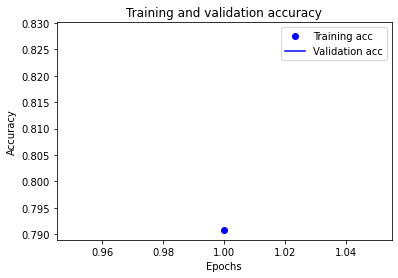

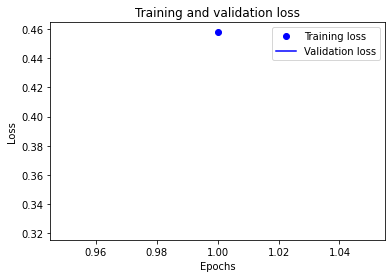

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [35]:
results = model.evaluate(X_test, y_test)

18731/18731 [==============================] - 36s 2ms/step - loss: 0.3220 - accuracy: 0.8274


In [36]:
loss = results[0]
accuracy = results[1]

In [37]:
accuracy

0.8274155855178833

In [38]:
model.save( 'kaggle/working/taxiMultiAttributeClassifier.h5')

In [39]:
with open('taxiMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

In [40]:
model = load_model('kaggle/working/taxiMultiAttributeClassifier.h5')

In [41]:
with open('taxiMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [42]:
testString = ['Leif']

In [43]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=maxLength)

In [44]:
predictions = model.predict(testData)

In [45]:
predictions

array([[2.7616536e-05, 1.7831313e-10, 3.3279974e-03, 9.9366790e-01,
        1.2415417e-05, 5.4437129e-07, 5.5832177e-05, 5.7670547e-07,
        4.7913690e-10, 9.1645724e-10, 1.0737517e-11, 4.9168540e-07,
        6.3462735e-10, 2.0241457e-04, 2.7042355e-03]], dtype=float32)

In [46]:
mapping[np.argmax(predictions[0])]

'f_name'